Import libraries

In [52]:
import pandas as pd
import pathlib
from collections import Counter
from debater_python_api.api.debater_api import DebaterApi
import matplotlib.pyplot as plt
import seaborn as sns

Load data from `keypoints.ipynb` into a dataframe

In [2]:
df = pd.read_csv('../data/df_merge.csv')

Load API key for IBM Debater

In [3]:
apikey_path = pathlib.Path('../APIkey.txt')
api_key = apikey_path.read_text().strip()

Create a client for the IBM Debater API Term Wikifier service

In [4]:
debater_api = DebaterApi(apikey=api_key)
term_wikifier_client = debater_api.get_term_wikifier_client()

Create a function to map medical transcription texts to a set of mentions in Wikipedia

In [5]:
def get_sentence_to_mentions(sentences_texts):
    mentions_list = term_wikifier_client.run(sentences_texts)
    sentence_to_mentions = {}

    for sentence_text, mentions in zip(sentences_texts, mentions_list):
        sentence_to_mentions[sentence_text] = set([mention["concept"]["title"] for mention in mentions])
    
    return sentence_to_mentions

Call this function to gather all mentions related to a medical transcription and tally them

In [6]:
terms = {}

for kp in set(df["kp"].values):
    sentence_to_mentions = get_sentence_to_mentions(df["sentence_text"][df["kp"] == kp].values)
    all_mentions = [mention for sentence in sentence_to_mentions for mention in sentence_to_mentions[sentence]]
    term_count = dict(Counter(all_mentions))
    # Remove mentions of "history"
    if "History" in term_count.keys():
        term_count.pop("History")
    terms[kp] = term_count

TermWikifierClient: 100%|██████████| 115/115 [00:00<00:00, 135.55it/s]











TermWikifierClient: 100%|██████████| 731/731 [00:02<00:00, 300.15it/s]

TermWikifierClient: 100%|██████████| 731/731 [00:15<00:00, 300.15it/s]

Display the results for one sample diagnosis

In [10]:
df_check = pd.DataFrame(list(terms["Routine colorectal cancer screening"].items()), columns=["Term", "Count"]).sort_values(by="Count", ascending=False)
df_check.head(10)

TermWikifierClient: 100%|██████████| 44/44 [04:04<00:00,  5.57s/it]


,Term,Count
5,Bladder cancer,5
63,Cystoscopy,4
24,Female,4
14,Patient,4
9,Colonoscopy,3
20,Squamous cell carcinoma,3
1,Colorectal cancer,3
83,Bilateralism,3
6,Urinary bladder,3
56,CT scan,3


Remove rows where `keypoint` is `none` from the dataframe and count the size of each `keypoint` cluster

In [11]:
df_clean = df[df["kp"] != "none"]
df_clean["kp"].value_counts()

Worrisome skin lesion                                          115
Routine colorectal cancer screening                             44
Abnormal uterine bleeding                                       24
No complications were encountered throughout the procedure.     20
Spontaneous vaginal delivery                                     5
Obsessive compulsive disorder.                                   2
Name: kp, dtype: int64

Visualize the above as a bar chart

<AxesSubplot: xlabel='count', ylabel='kp'>

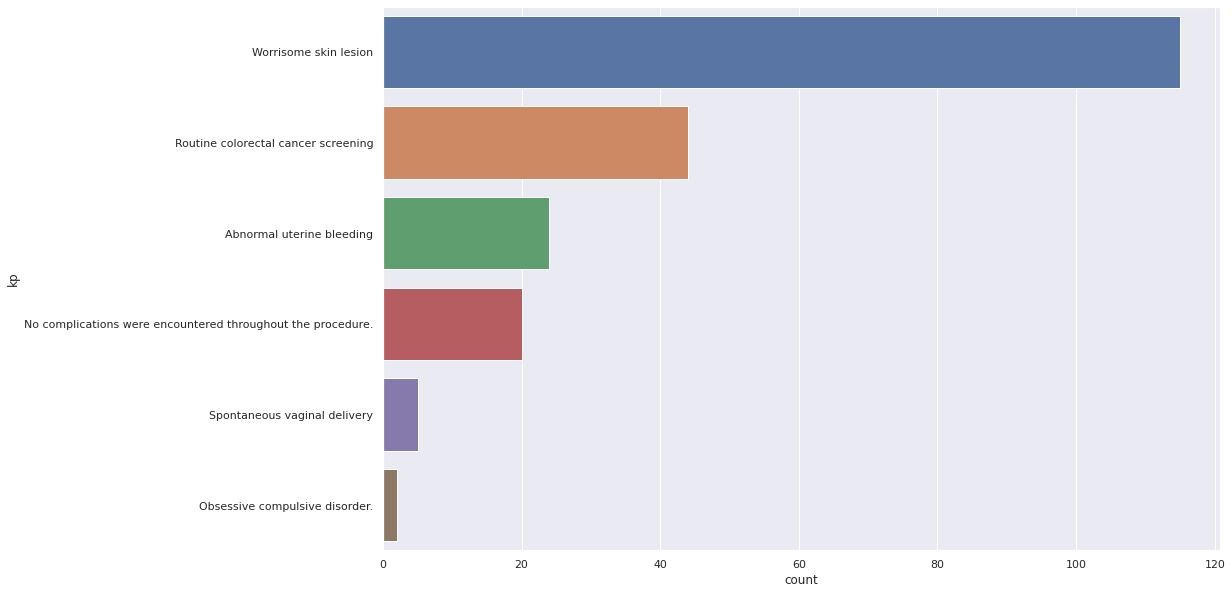

In [54]:
sns.countplot(y="kp", data=df_clean)

Visualize relative frequency of key points grouped by medical specialty

<AxesSubplot: xlabel='count', ylabel='medical_specialty_new'>

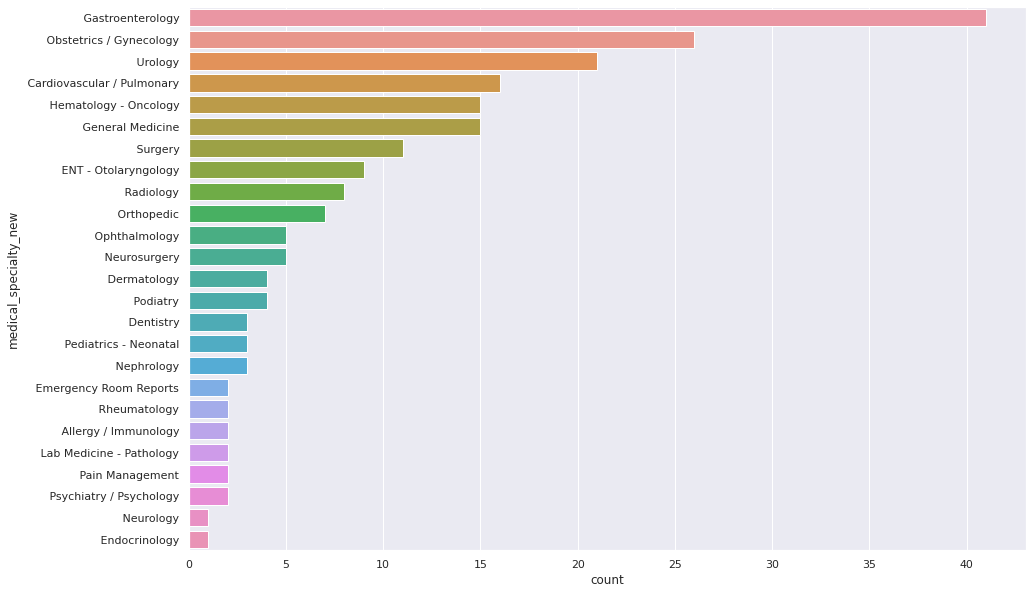

In [13]:
sns.set(rc={"figure.figsize": (15, 10)})
sns.countplot(y="medical_specialty_new", data=df_clean, order=df_clean["medical_specialty_new"].value_counts().index)

Visualize the distribution of medical specialties for each key point

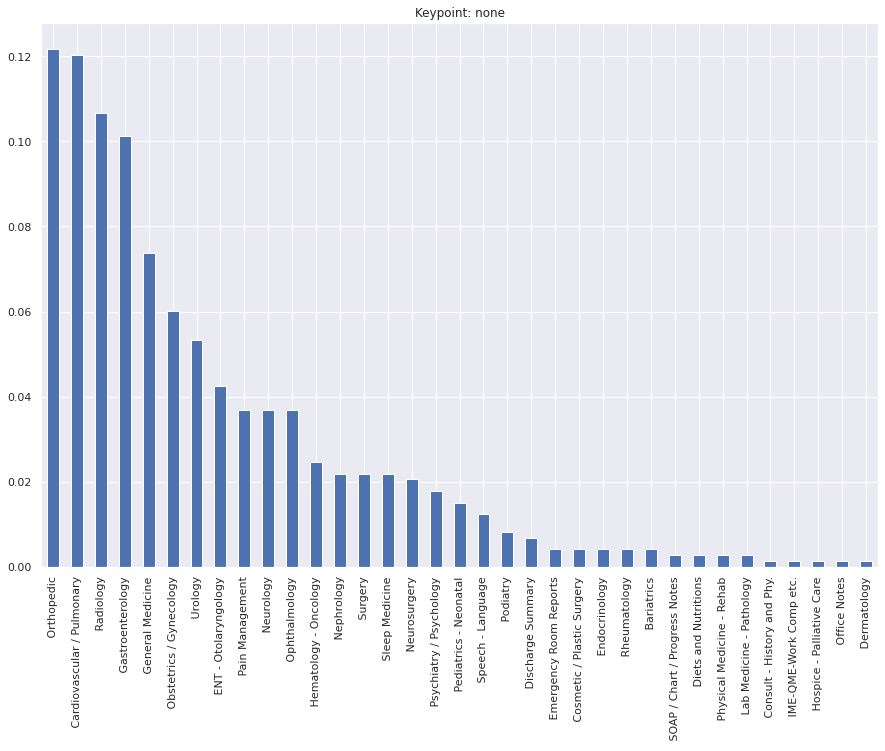

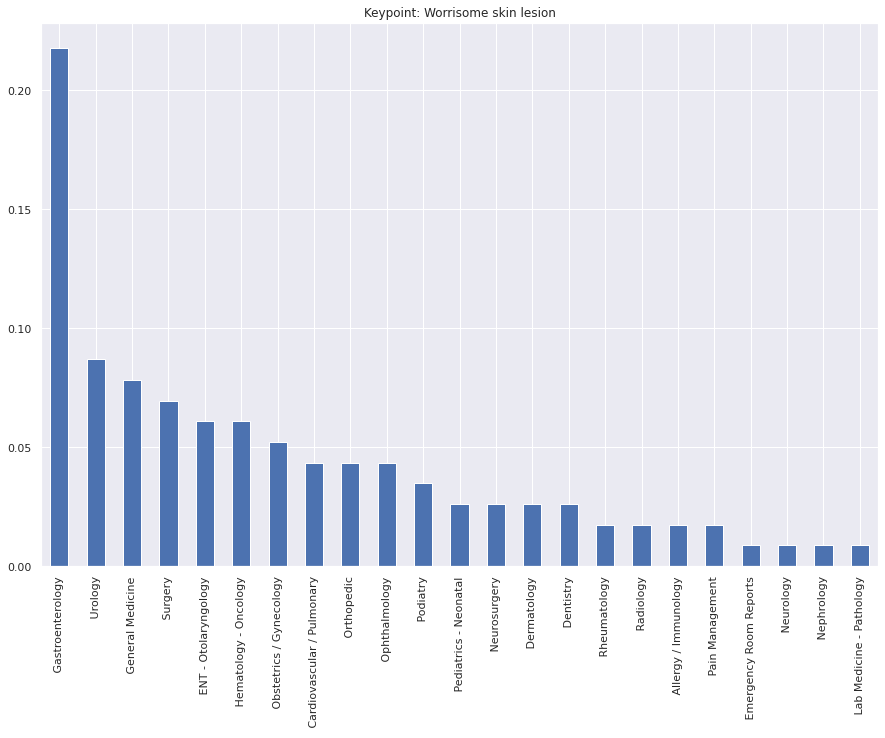

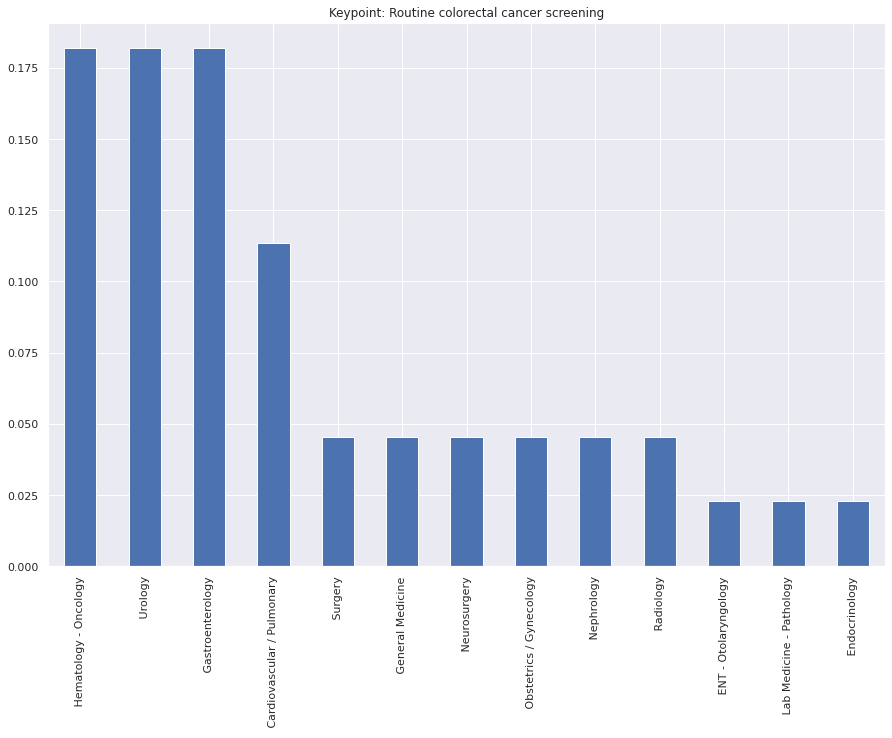

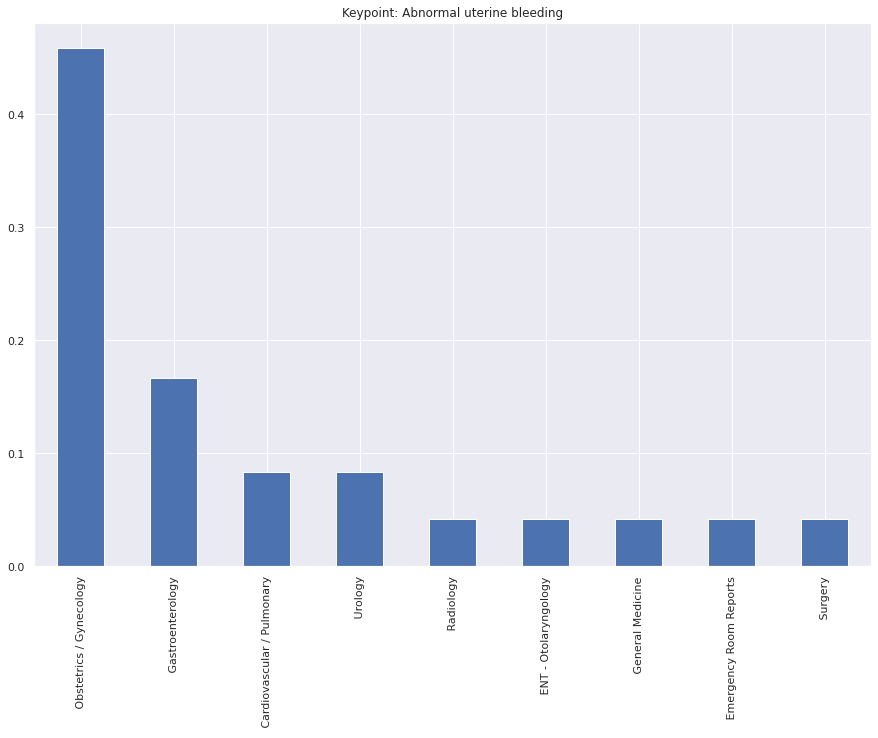

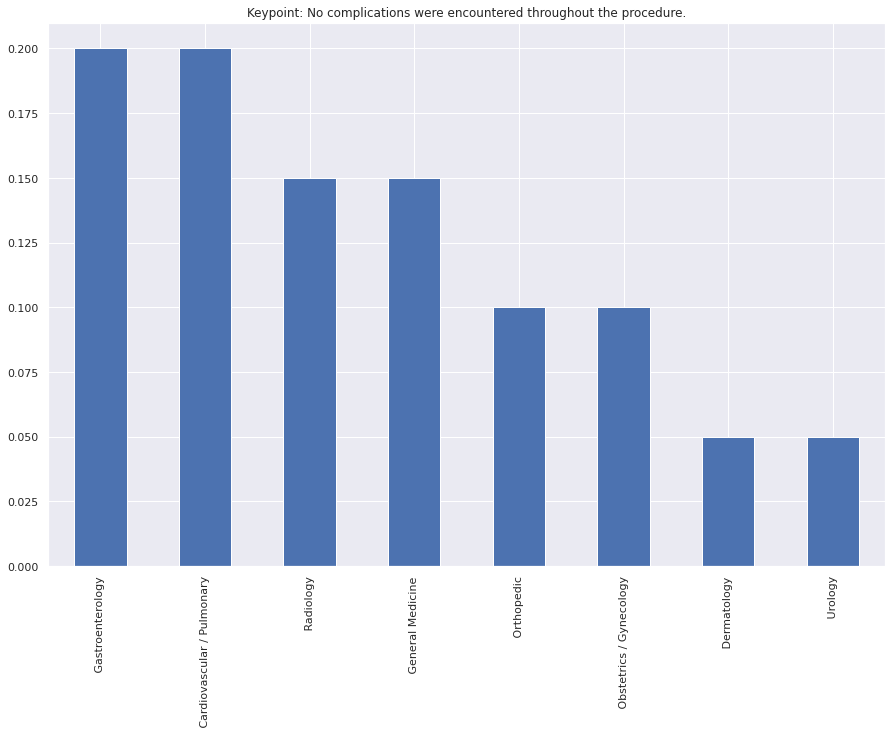

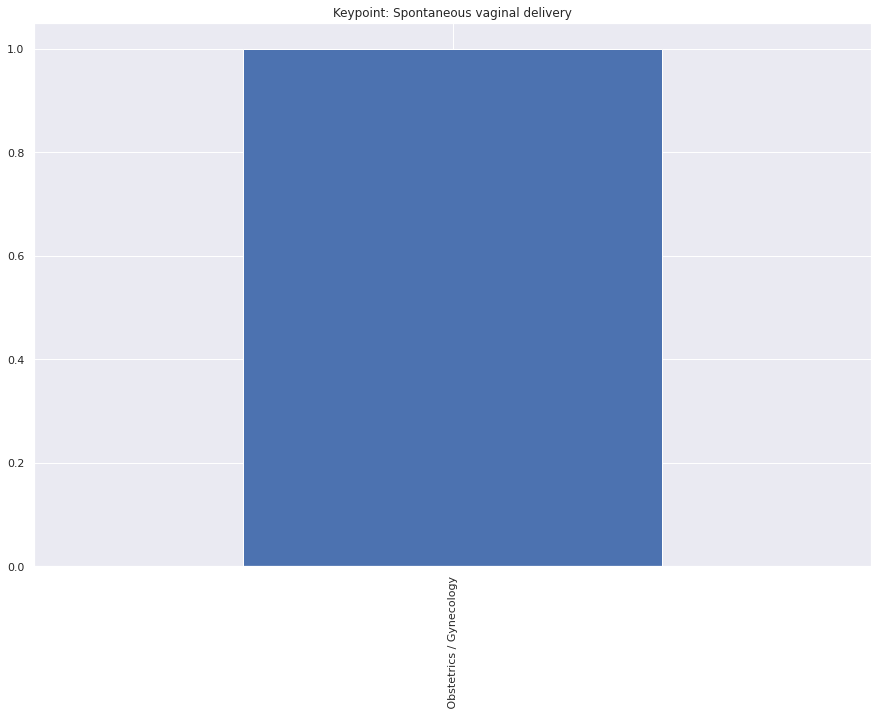

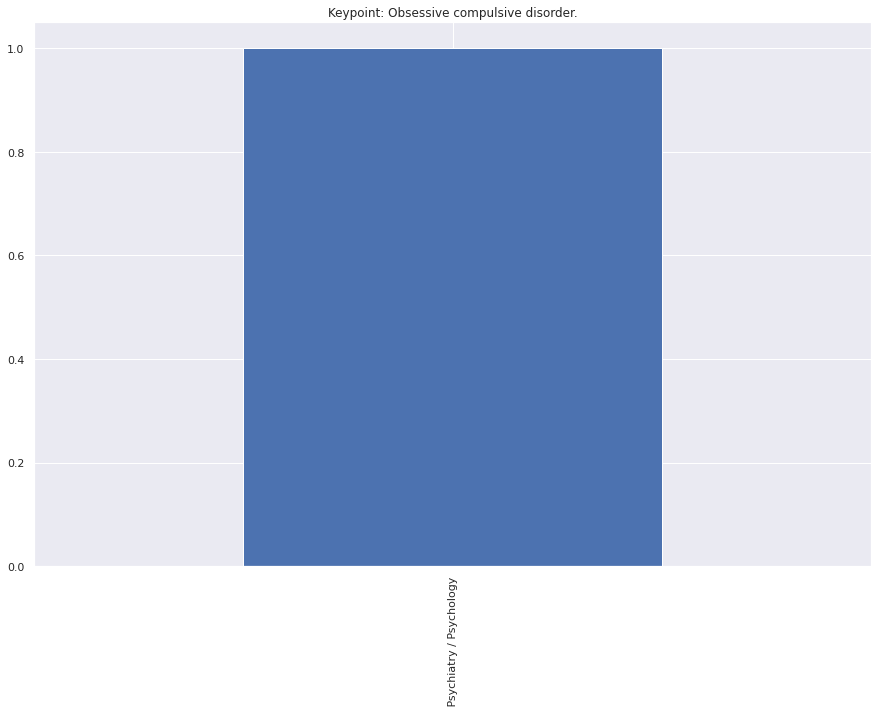

In [57]:
for kp in df["kp"].value_counts().index:
    data = df[df["kp"] == kp]["medical_specialty_new"].value_counts(normalize=True)
    data.plot(kind="bar")
    plt.title("Keypoint: " + kp)
    plt.show()

Visualize the top 10 terms from Wikipedia for each key point

In [29]:
df_top10terms = pd.DataFrame()
for term in terms.keys():
    df_top10_temp = pd.DataFrame(list(terms[term].items()), columns=["Term", "Count"]).sort_values(by="Count", ascending=False).iloc[:10, :]
    df_top10_temp['Keypoint'] = term
    df_top10terms = pd.concat([df_top10terms, df_top10_temp], axis=0, ignore_index=True)

In [30]:
df_top10terms.head(20)

,Term,Count,Keypoint
0,Patient,29,Worrisome skin lesion
1,Female,12,Worrisome skin lesion
2,Pain,9,Worrisome skin lesion
3,Cholecystitis,8,Worrisome skin lesion
4,Skin,7,Worrisome skin lesion
5,Lesion,6,Worrisome skin lesion
6,CT scan,6,Worrisome skin lesion
7,Chronic condition,6,Worrisome skin lesion
8,Inguinal hernia,5,Worrisome skin lesion
9,Area,5,Worrisome skin lesion


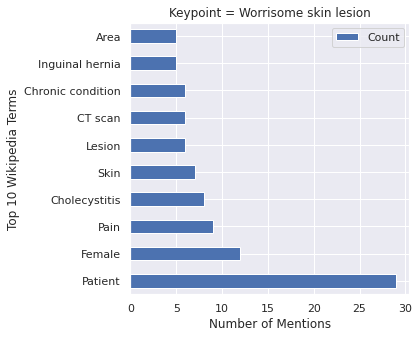

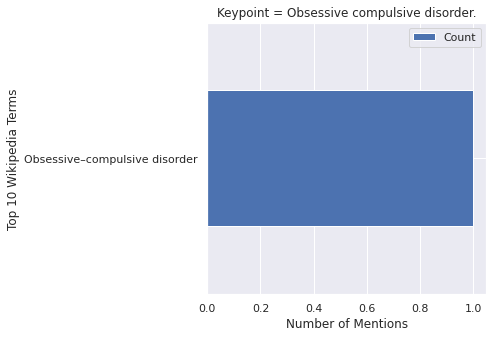

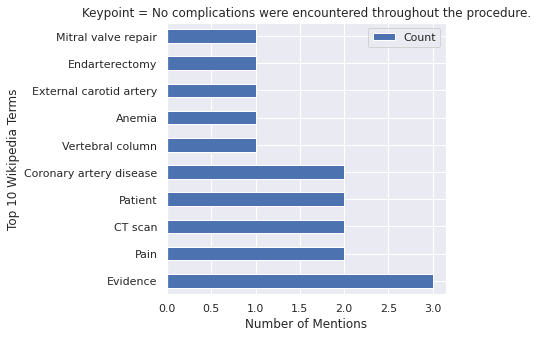

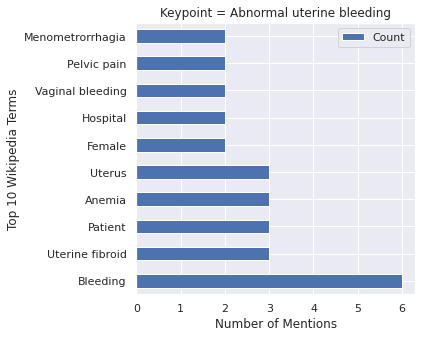

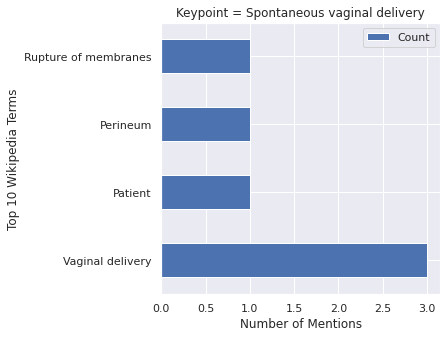

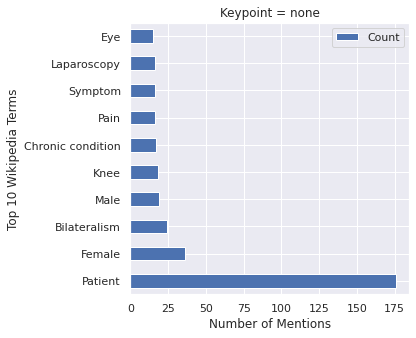

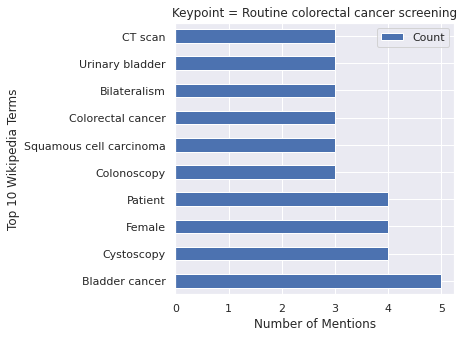

In [55]:
for term in terms.keys():
    df_top10terms[df_top10terms['Keypoint'] == term].plot(x='Term', kind="barh", figsize=(5,5), title=f"Keypoint = {term}", xlabel="Number of Mentions", ylabel="Top 10 Wikipedia Terms")

Store the cleaned dataframe as CSV for subsequent use

In [51]:
df_clean.to_csv('../data/df_clean.csv', index=False)